Chapter 3: Hands on machine learning, Classification

In [75]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl 

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib.pyplot as plt

In [7]:
some_digit = X[6]
some_digit_image = some_digit.reshape(28, 28)

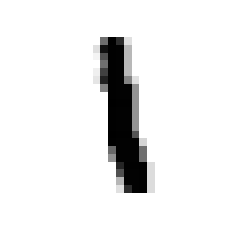

In [8]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [9]:
y[6] #confirm that it is '1'

'1'

In [76]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [10]:
y = y.astype(np.uint8) #convert from string to int

In [11]:
#Create test and train sets

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
#creating a target vector for classification: like hot-dog/not hot-dog, but for the number 1
y_train_1 = (y_train == 1) # true for all pictures that are 1, false for everything else
y_test_1 = (y_test == 1) 

## Ask Jake about this... 

In [13]:
from sklearn.linear_model import SGDClassifier #Stochastic Gradient Decent

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
some_digit = X[6]

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
## Measuring accuracy with cross validation

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_1, cv=3, scoring='accuracy')

array([0.9878 , 0.98095, 0.99005])

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [20]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)


for train_index, test_index in skfolds.split(X_train, y_train_1):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_1[train_index]
    X_test_fold =X_train[test_index]
    y_test_fold = y_train_1[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9878
0.98095
0.99005


In [21]:
from sklearn.base import BaseEstimator

class Never1Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
never_1_clf = Never1Classifier()
cross_val_score(never_1_clf, X_train, y_train_1, cv=3, scoring="accuracy")

array([0.88595, 0.8859 , 0.89105])

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_1, y_train_pred)

array([[52917,   341],
       [  483,  6259]])

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_1, y_train_pred)

0.9483333333333334

In [26]:
recall_score(y_train_1, y_train_pred)

0.9283595372293089

In [27]:
#compute F1 score: harmonic mean of recall and percision 

from sklearn.metrics import f1_score
f1_score(y_train_1, y_train_pred)

0.9382401439064609

In [28]:
# digging into the threshold

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([14583.21846657])

In [29]:
threshold = 15000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [30]:
# cross validation to return the classifer scores. Trying to figure out what the best threshold is. 

y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3, method='decision_function')


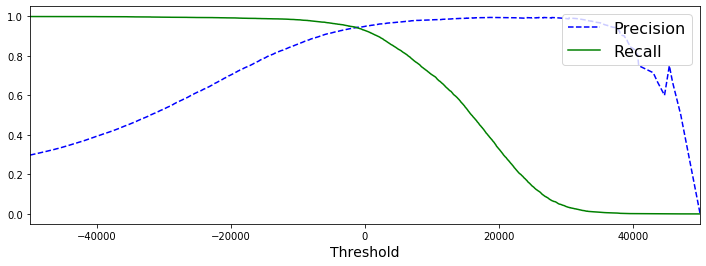

In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12, 4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc='upper right', fontsize = 16)
    plt.xlabel('Threshold', fontsize = 14)
    plt.xlim(left=-50000, right=50000)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(12, 4))
    plt.plot(recalls, precisions,label='Precision')
    plt.legend(loc='upper right', fontsize = 16)
    plt.xlabel('Recall', fontsize = 14)


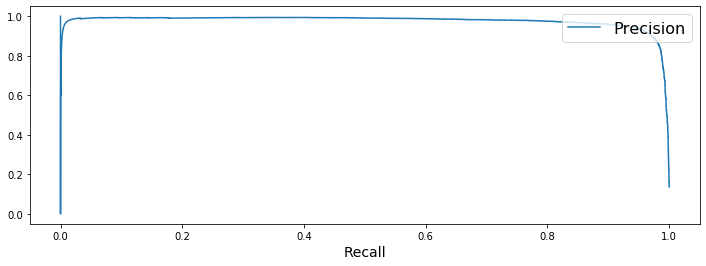

In [33]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [34]:
#ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)

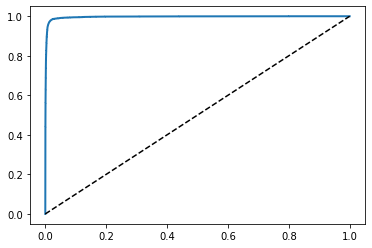

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv=3, method="predict_proba")

In [37]:
y_scores_forest = y_prob_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_1, y_scores_forest)

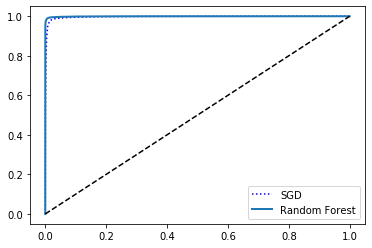

In [38]:
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [39]:
## Multiclass classification

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([1], dtype=uint8)

In [40]:
some_digit_scores = (svm_clf.decision_function([some_digit]))
some_digit_scores

array([[-0.31693195,  9.31618719,  5.11128022,  7.29465689,  3.81901753,
         1.75872355,  0.71796394,  3.75679177,  8.29046254,  4.77753155]])

In [41]:
np.argmax(some_digit_scores)

1

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([1], dtype=uint8)

In [43]:
sgd_clf.decision_function([some_digit])

array([[-61738.68255702,  12505.66025648,  -5238.67111022,
          -143.17306469,  -9621.21903686,  -7720.52688593,
         -6192.44338928, -14882.43029463,  -1378.38904284,
         -7108.80911604]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [46]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [48]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [55]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

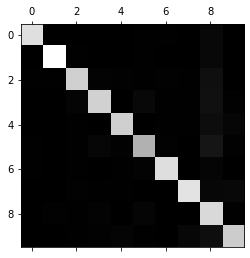

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [59]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

In [60]:
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

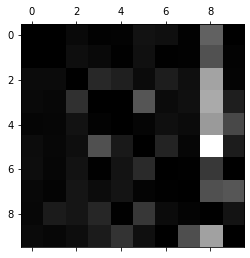

In [64]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

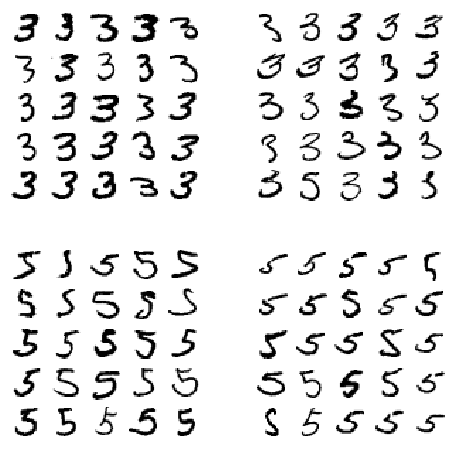

In [79]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

In [80]:
## Multioutput classification